Bắt đầu huấn luyện trên cpu...
Epoch 20/200 | Loss: -0.0079 | Avg Reward: 81.10 | actor_loss: 0.0000 | entropy: 0.7935 | avg_reward: -0.0000

Policy hiện tại:
State 0: [1:0.40, 2:0.48, 3:0.12]
State 1: [1:0.31, 2:0.34, 3:0.35]
State 2: [1:0.12, 2:0.27, 3:0.61]
State 3: [1:0.06, 2:0.07, 3:0.87]
State 4: [1:0.09, 2:0.87, 3:0.04]
State 5: [1:0.89, 2:0.05, 3:0.06]
State 6: [1:0.16, 2:0.45, 3:0.39]
Epoch 40/200 | Loss: -0.0046 | Avg Reward: 101.00 | actor_loss: -0.0000 | entropy: 0.4590 | avg_reward: 0.0000

Policy hiện tại:
State 0: [1:0.23, 2:0.73, 3:0.04]
State 1: [1:0.31, 2:0.34, 3:0.35]
State 2: [1:0.04, 2:0.27, 3:0.69]
State 3: [1:0.03, 2:0.03, 3:0.95]
State 4: [1:0.04, 2:0.95, 3:0.02]
State 5: [1:0.99, 2:0.01, 3:0.01]
State 6: [1:0.07, 2:0.68, 3:0.25]
Epoch 60/200 | Loss: -0.0027 | Avg Reward: 101.00 | actor_loss: -0.0000 | entropy: 0.2683 | avg_reward: 0.0000

Policy hiện tại:
State 0: [1:0.09, 2:0.89, 3:0.02]
State 1: [1:0.31, 2:0.34, 3:0.35]
State 2: [1:0.03, 2:0.20, 3:0.77]
State

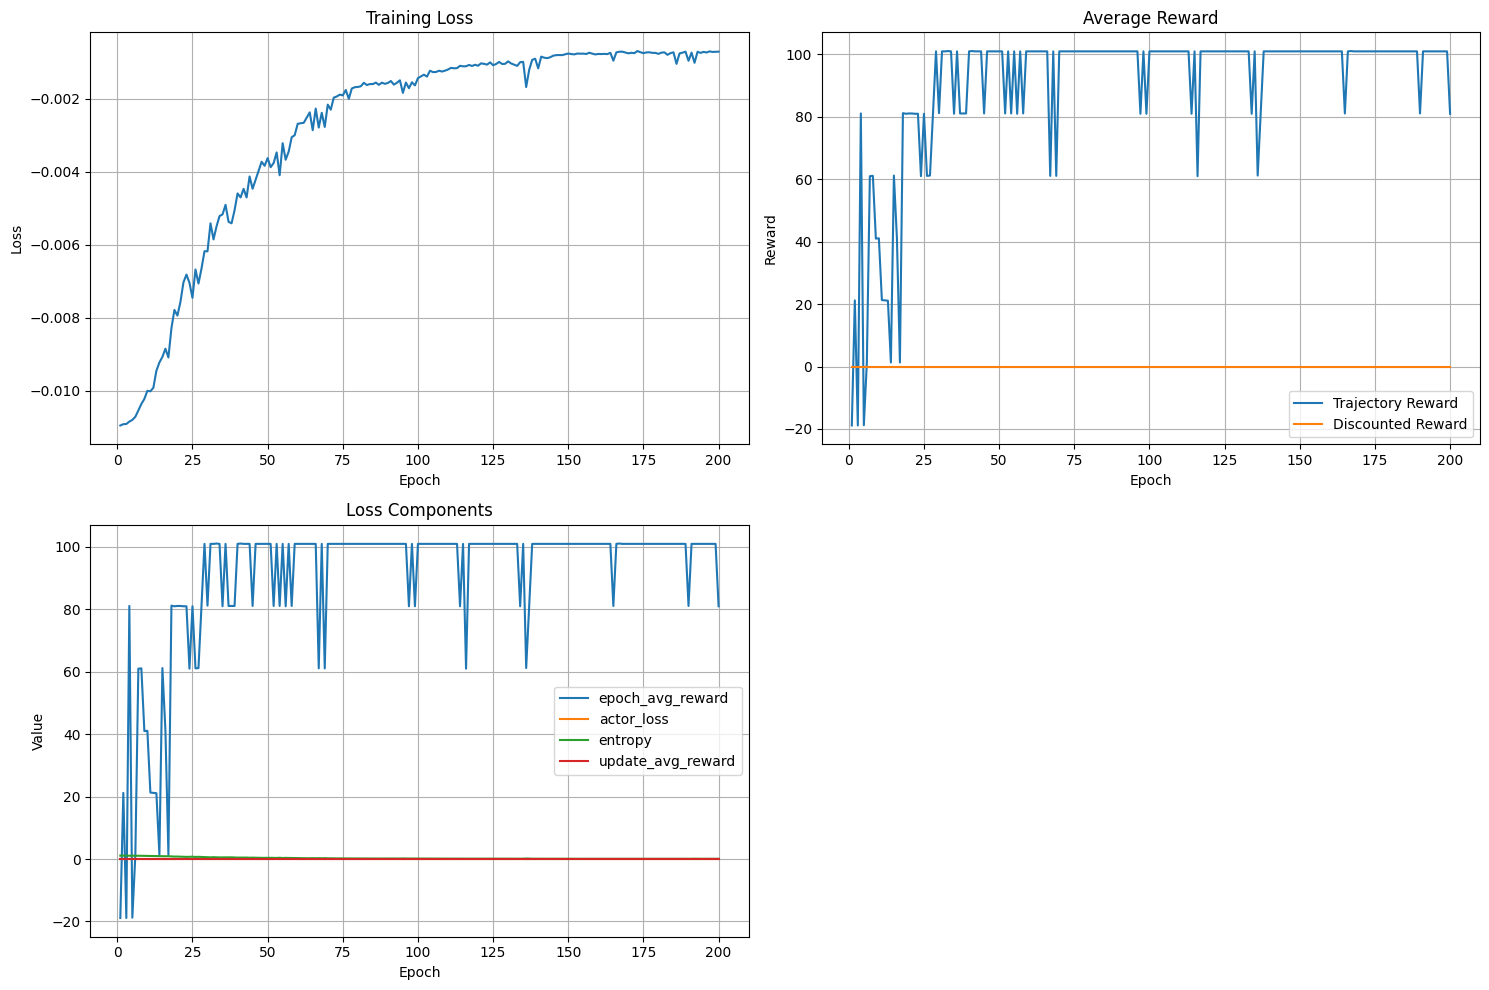

Đã lưu biểu đồ tại game7_logs/training_history.png
Đánh giá trên 10 episodes: Điểm trung bình = 101.00

Policy cuối cùng:
State 0: Best action = 2 (Optimal: 3), Probs: [1:0.02, 2:0.98, 3:0.00]
State 1: Best action = 3 (Optimal: 3), Probs: [1:0.31, 2:0.34, 3:0.35]
State 2: Best action = 3 (Optimal: 3), Probs: [1:0.03, 2:0.20, 3:0.77]
State 3: Best action = 3 (Optimal: 3), Probs: [1:0.00, 2:0.00, 3:1.00]
State 4: Best action = 2 (Optimal: 2), Probs: [1:0.00, 2:1.00, 3:0.00]
State 5: Best action = 1 (Optimal: 1), Probs: [1:1.00, 2:0.00, 3:0.00]
State 6: Best action = 2 (Optimal: 0), Probs: [1:0.01, 2:0.89, 3:0.10]

Ma trận trọng số (7x3):
[[-0.5356358   3.2731633  -2.492959  ]
 [-0.08291858 -0.00470482  0.04938664]
 [-1.7421441   0.22867362  1.5855318 ]
 [-2.59266    -3.2088935   4.560474  ]
 [-2.0422375   3.9367032  -3.3019414 ]
 [ 3.660637   -3.3263278  -2.8833115 ]
 [-2.1246564   2.306857    0.12917742]]


In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import random

class Environment:
    """Giao diện môi trường cơ bản"""
    def reset(self):
        """Reset môi trường, trả về state ban đầu"""
        pass
    
    def step(self, action):
        """
        Thực hiện hành động, trả về:
        - next_state
        - reward
        - done (cờ kết thúc)
        - info (thông tin bổ sung)
        """
        pass

class Agent:
    """Giao diện agent cơ bản"""
    def __init__(self, model):
        self.model = model
    
    def act(self, state, **kwargs):
        """
        Chọn hành động dựa trên state
        Trả về action và các thông tin liên quan (log prob, value, etc.)
        """
        pass
    
    def update(self, trajectories):
        """
        Cập nhật agent dựa trên trajectories
        Trả về loss và các thông tin liên quan
        """
        pass

class Trainer:
    def __init__(self, agent, env, device='cpu', log_dir='logs'):
        self.agent = agent
        self.env = env
        self.device = device
        
        # Đảm bảo model nằm trên đúng device
        if hasattr(agent, 'model'):
            self.agent.model.to(device)
        
        # Tạo thư mục log
        self.log_dir = log_dir
        os.makedirs(log_dir, exist_ok=True)
        
        # Lịch sử huấn luyện
        self.history = defaultdict(list)
    
    def collect_trajectories(self, num_trajectories=1, max_steps=1000):
        trajectories = []
        
        for _ in range(num_trajectories):
            state = self.env.reset()
            trajectory = []
            done = False
            step_count = 0
            
            while not done and step_count < max_steps:
                # Agent chọn hành động
                action_info = self.agent.act(state)
                
                # Thực hiện hành động trong môi trường
                next_state, reward, done, info = self.env.step(action_info['action'])
                
                # Lưu transition
                transition = {
                    'state': state,
                    'action_info': action_info,
                    'reward': reward,
                    'next_state': next_state,
                    'done': done,
                    'info': info
                }
                trajectory.append(transition)
                
                # Cập nhật state
                state = next_state
                step_count += 1
            
            trajectories.append(trajectory)
        
        return trajectories
    
    def train(self, num_epochs=100, trajectories_per_epoch=1, log_interval=10):
        print(f"Bắt đầu huấn luyện trên {self.device}...")
        
        for epoch in range(1, num_epochs + 1):
            # Thu thập trajectories
            trajectories = self.collect_trajectories(
                num_trajectories=trajectories_per_epoch
            )
            
            # Cập nhật agent
            loss, loss_info = self.agent.update(trajectories)
            
            # Tính toán reward trung bình
            total_rewards = []
            for trajectory in trajectories:
                trajectory_reward = sum(t['reward'] for t in trajectory)
                total_rewards.append(trajectory_reward)
            avg_reward = np.mean(total_rewards)
            
            # Lưu lịch sử
            self.history['epoch'].append(epoch)
            self.history['loss'].append(loss)
            self.history['epoch_avg_reward'].append(avg_reward)  # Đổi tên để phân biệt

            for key, value in loss_info.items():
                # Đổi tên key 'avg_reward' trong loss_info
                if key == 'avg_reward':
                    self.history['update_avg_reward'].append(value)
                else:
                    self.history[key].append(value)
            
            # Log kết quả
            if epoch % log_interval == 0:
                log_str = (f"Epoch {epoch}/{num_epochs} | "
                          f"Loss: {loss:.4f} | "
                          f"Avg Reward: {avg_reward:.2f}")
                for key, value in loss_info.items():
                    log_str += f" | {key}: {value:.4f}"
                print(log_str)
                
                # In policy hiện tại
                print("\nPolicy hiện tại:")
                for state in range(7):
                    state_vec = np.zeros(7)
                    state_vec[state] = 1.0
                    action_info = self.agent.act(state_vec, deterministic=True)
                    probs = action_info['probs'].detach().numpy()[0]
                    print(f"State {state}: [1:{probs[0]:.2f}, 2:{probs[1]:.2f}, 3:{probs[2]:.2f}]")
        
        print("Huấn luyện hoàn tất!")
        self.plot_training_history()
    
    def plot_training_history(self):
        """Vẽ biểu đồ lịch sử huấn luyện"""
        plt.figure(figsize=(15, 10))
        
        # Loss
        plt.subplot(2, 2, 1)
        plt.plot(self.history['epoch'], self.history['loss'])
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        
        # Reward
        plt.subplot(2, 2, 2)
        plt.plot(self.history['epoch'], self.history['epoch_avg_reward'], label='Trajectory Reward')
        plt.plot(self.history['epoch'], self.history['update_avg_reward'], label='Discounted Reward')
        plt.legend()
        plt.title('Average Reward')
        plt.xlabel('Epoch')
        plt.ylabel('Reward')
        plt.grid(True)
        
        # Các thành phần loss
        loss_components = [k for k in self.history.keys() 
                          if k not in ['epoch', 'loss', 'avg_reward']]
        
        if loss_components:
            plt.subplot(2, 2, 3)
            for component in loss_components:
                plt.plot(self.history['epoch'], self.history[component], label=component)
            plt.title('Loss Components')
            plt.xlabel('Epoch')
            plt.ylabel('Value')
            plt.legend()
            plt.grid(True)
        
        plt.tight_layout()
        plot_path = os.path.join(self.log_dir, 'training_history.png')
        plt.savefig(plot_path)
        plt.show()
        print(f"Đã lưu biểu đồ tại {plot_path}")
    
    def evaluate(self, num_episodes=10):
        """Đánh giá agent"""
        total_rewards = []
        
        for _ in range(num_episodes):
            state = self.env.reset()
            done = False
            episode_reward = 0
            
            while not done:
                action_info = self.agent.act(state, deterministic=True)
                state, reward, done, _ = self.env.step(action_info['action'])
                episode_reward += reward
            
            total_rewards.append(episode_reward)
        
        avg_reward = np.mean(total_rewards)
        print(f"Đánh giá trên {num_episodes} episodes: Điểm trung bình = {avg_reward:.2f}")
        return avg_reward


class Game7Env(Environment):
    """Môi trường trò chơi 7"""
    def __init__(self):
        self.reset()
    
    def reset(self):
        """Khởi tạo trạng thái mới"""
        self.current = 0
        self.done = False
        return self._get_state()
    
    def _get_state(self):
        """Trả về one-hot vector của state"""
        state = np.zeros(7, dtype=np.float32)
        state[min(self.current, 6)] = 1.0
        return state
    
    def step(self, action):
        """
        Thực hiện hành động
        
        Args:
            action: 0=1, 1=2, 2=3
            
        Returns:
            next_state, reward, done, info
        """
        if self.done:
            raise ValueError("Game đã kết thúc, cần reset")
        
        # Người chơi thực hiện hành động
        player_move = action + 1
        self.current += player_move
        
        # Kiểm tra thua ngay lập tức nếu vượt quá 7
        if self.current >= 7:
            self.done = True
            return self._get_state(), -100, self.done, {}
        
        # Đối thủ đi ngẫu nhiên 1-3
        opponent_move = random.randint(1, 3)
        self.current += opponent_move
        
        # Kiểm tra kết quả sau khi cả hai đi
        if self.current >= 7:
            # Người chơi thắng nếu đối thủ buộc phải vào 7
            reward = 100
            self.done = True
        else:
            reward = 1  # Đi hợp lệ
            self.done = False
        
        return self._get_state(), reward, self.done, {}
    
    def render(self):
        """Hiển thị trạng thái hiện tại"""
        print(f"Số hiện tại: {self.current}/7")


class Game7Policy(nn.Module):
    """Mô hình chính sách cho Game 7: Ma trận trọng số 7x3"""
    def __init__(self):
        super().__init__()
        # Khởi tạo ma trận trọng số với giá trị ngẫu nhiên nhỏ
        self.weights = nn.Parameter(torch.randn(7, 3) * 0.1)
    
    def forward(self, x):
        # x là one-hot vector (batch_size, 7)
        # Lấy trọng số tương ứng với state
        state_index = torch.argmax(x, dim=1)
        return self.weights[state_index]


class Game7Agent(Agent):
    """Agent cho trò chơi 7"""
    def __init__(self, model, lr=0.1):
        super().__init__(model)
        self.optimizer = optim.Adam(model.parameters(), lr=lr)
    
    def act(self, state, deterministic=False):
        """
        Chọn hành động dựa trên state
        
        Args:
            state: Trạng thái hiện tại (one-hot vector)
            deterministic: Có chọn hành động deterministically không
            
        Returns:
            action_info: Thông tin về hành động
        """
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        logits = self.model(state_tensor)
        probs = torch.softmax(logits, dim=-1)
        
        if deterministic:
            action = torch.argmax(probs).item()
        else:
            dist = torch.distributions.Categorical(probs)
            action = dist.sample().item()
        
        return {
            'action': action,
            'logits': logits,
            'probs': probs
        }
    
    def update(self, trajectories):
        """
        Cập nhật agent dựa trên trajectories với PPO
        """
        # 1. Chuẩn bị dữ liệu
        states, actions, rewards, old_log_probs = [], [], [], []
        
        for trajectory in trajectories:
            # Tính discounted returns cho toàn bộ trajectory
            discounted_rewards = []
            discounted_reward = 0
            
            for transition in reversed(trajectory):
                discounted_reward = transition['reward'] + 0.99 * discounted_reward
                discounted_rewards.insert(0, discounted_reward)
            
            for i, transition in enumerate(trajectory):
                states.append(transition['state'])
                actions.append(transition['action_info']['action'])
                rewards.append(discounted_rewards[i])
                
                # Tính old log probability
                probs = transition['action_info']['probs'][0]
                old_log_probs.append(torch.log(probs[actions[-1]]))
        
        # Chuyển sang tensor
        states_tensor = torch.tensor(states, dtype=torch.float32)
        actions_tensor = torch.tensor(actions, dtype=torch.long)
        rewards_tensor = torch.tensor(rewards, dtype=torch.float32)
        old_log_probs_tensor = torch.stack(old_log_probs)
        
        # 2. Tính toán loss PPO
        # Chuẩn hóa rewards
        rewards_tensor = (rewards_tensor - rewards_tensor.mean()) / (rewards_tensor.std() + 1e-8)
        
        # Lấy log probability mới
        logits = self.model(states_tensor)
        probs = torch.softmax(logits, dim=-1)
        dist = torch.distributions.Categorical(probs)
        new_log_probs = dist.log_prob(actions_tensor)
        
        # Tính ratio
        ratio = torch.exp(new_log_probs - old_log_probs_tensor.detach())
        
        # PPO loss
        advantages = rewards_tensor
        surr1 = ratio * advantages
        surr2 = torch.clamp(ratio, 0.8, 1.2) * advantages
        actor_loss = -torch.min(surr1, surr2).mean()
        
        # Entropy loss (khuyến khích exploration)
        entropy = dist.entropy().mean()
        entropy_bonus = 0.01 * entropy
        
        # Tổng loss
        total_loss = actor_loss - entropy_bonus
        
        # 3. Cập nhật tham số
        self.optimizer.zero_grad()
        total_loss.backward()
        self.optimizer.step()
        
        # 4. Trả về thông tin loss
        loss_info = {
            'actor_loss': actor_loss.item(),
            'entropy': entropy.item(),
            'avg_reward': rewards_tensor.mean().item()
        }
        
        return total_loss.item(), loss_info


# Huấn luyện
if __name__ == "__main__":
    # Tạo môi trường và agent
    env = Game7Env()
    model = Game7Policy()
    agent = Game7Agent(model, lr=0.1)  # Learning rate cao hơn cho bài toán nhỏ
    device = 'cpu'  # Bài toán nhỏ, không cần GPU
    
    # Tạo trainer
    trainer = Trainer(
        agent=agent,
        env=env,
        device=device,
        log_dir='game7_logs'
    )
    
    # Huấn luyện
    trainer.train(
        num_epochs=200,
        trajectories_per_epoch=10,  # Thu thập nhiều trajectories hơn
        log_interval=20
    )
    
    # Đánh giá
    trainer.evaluate(num_episodes=10)
    
    # In policy cuối cùng
    print("\nPolicy cuối cùng:")
    for state in range(7):
        state_vec = np.zeros(7)
        state_vec[state] = 1.0
        action_info = agent.act(state_vec, deterministic=True)
        probs = action_info['probs'].detach().numpy()[0]
        best_action = np.argmax(probs) + 1
        
        # Tính toán nước đi tối ưu
        optimal_move = min(3, 6 - state)  # Đi đủ để đến 6 (đối thủ sẽ vào 7)
        
        print(f"State {state}: Best action = {best_action} (Optimal: {optimal_move}), "
              f"Probs: [1:{probs[0]:.2f}, 2:{probs[1]:.2f}, 3:{probs[2]:.2f}]")
    
    # In ma trận trọng số
    print("\nMa trận trọng số (7x3):")
    print(model.weights.detach().numpy())